In [2]:
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import bernoulli, cauchy, norm, gamma, poisson, binom, uniform, laplace, expon, trim_mean, iqr, beta, chi2_contingency, kstwobign, kstest
from scipy.stats import anderson, shapiro, normaltest, weibull_min, geom
import statistics
from tqdm import tqdm
from matplotlib import rc
from math import pi, log, tan, sin, exp
from scipy.optimize import minimize
import scipy.special
import statsmodels.api as sm
import pandas as pd

# 1

In [3]:
m, n = 10000, 10000
r = np.array(range(1,m+1))
u = expon.rvs(loc=0, scale=1, size=(m,n))
u = [np.sort(u[i]) for i in (range(m))]
th = [np.mean(u[i]) for i in range(m)]
T = [np.sum(((2*np.array(range(1,n+1))-1)/(2*n) - expon.cdf(u[j], loc = 0, scale = th[j]))**2)+1/(12*n) for j in (range(m))]
with open('KfM_exp.txt', 'w') as f:
    f.writelines(f"{item}\n" for item in T)

In [4]:
# f = ECDF(T)
with open('KfM_exp.txt', 'r') as file:
    lines = file.read().splitlines()
lines = list(map(float, lines))
KfM_exp = ECDF(lines)

In [5]:
def kfm_exp(data, f, m, n, s):
    data = [np.sort(data[i]) for i in (range(m))]
    th = [np.mean(data[i]) for i in range(m)]
    r = np.array(range(1,n+1))
    T = [np.sum(((2*np.array(range(1,n+1))-1)/(2*n) - expon.cdf(data[j], loc = 0, scale = th[j]))**2)+1/(12*n) for j in (range(m))]
    pv =  np.sort(1-f(T))
    R = np.arange(1,m+1)/m
    plt.plot(pv, R)
    plt.plot(R,R, linestyle='dashed', color='gray')
    plt.title(s)

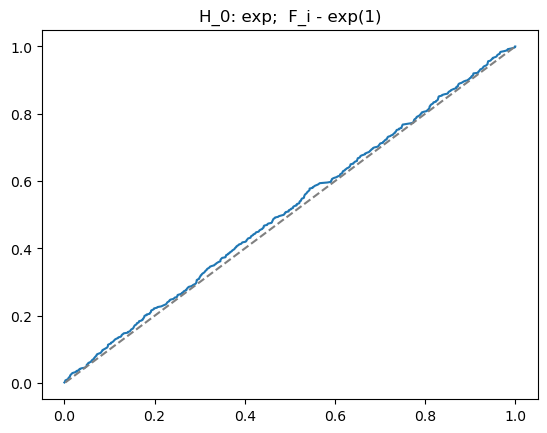

In [6]:
m, n = 500, 100
v = expon.rvs(loc=0, scale=1, size=(m,n))
kfm_exp(v, KfM_exp, m, n, 'H_0: exp;  F_i - exp(1)')

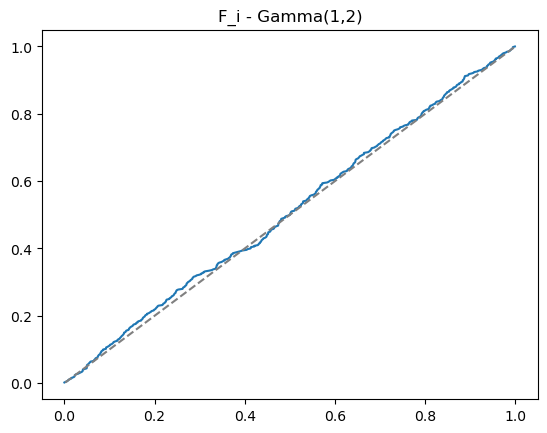

In [7]:
m, n = 500, 100
v = gamma.rvs(a=1, loc=0, scale=2, size=(m,n))
kfm_exp(v, KfM_exp, m, n, 'F_i - Gamma(1,2)')

# 2

In [8]:
def mle(data):
    return minimize(lkh, x0=2, args=data, bounds=[(0, None)]).x[0]

def lkh(x, data):
    r=0
    n = np.size(data)
    k = int(log(n)/log(2))
    c = int(n/k) #кол элементов в промежутке
    data = np.sort(data)
    t = k -(n - k*c) #число промежутков, где с попаданий (в остальных c+1)
    bins = [ ( data[c*i-1])*int(i<=t) + ( data[t*c-1+ (i-t)*(c+1)])*int(i>t) for i in range(1, k)] #границы промежутков, где-то надо заменить на +-inf
    p0=np.zeros(k)
    p0[0] = expon.cdf(bins[0], scale = x).item() #вероятность попадания в левый промежуток
    p0[k-1] = (1 - expon.cdf(bins[k-2], scale = x)).item() #правый
    for i in range(0, k-2): #остальные
        p0[i+1] = (expon.cdf(bins[i+1], scale = x) - expon.cdf(bins[i], scale = x)).item()
    obs = [c]*t + [c+1]*(k-t) #сколько попало в каждый промежуток
    r = np.sum (np.array([obs[j]*log(max(p0[j], 0.000001)) for j in range(k)])) #лог правдоподобия
    return -r

def chi1(data,m,n,s):
    k = int(log(n)/log(2))
    bins = [ [expon.ppf(i/k, loc = 0, scale=np.mean(data[j]) ) for i in range(k+1)] for j in range(m)]
    obs = [pd.cut(data[i], bins = bins[i]).value_counts().tolist() for i in range(m)]
    pv = np.sort([scipy.stats.chisquare(f_obs = obs[i]).pvalue for i in range(m)])
    R = np.arange(1,m+1)/m
    plt.plot(pv, R, label = s)
    plt.plot(R,R, linestyle='dashed', color='gray')
    plt.legend(title="test")

def chi2(data, m, n, s):
    k = int(log(n)/log(2))
    c = int(n/k) #кол элементов в промежутке
    data = [np.sort(data[i]) for i in range(m)]
    t = k-(n - k*c)
    bins = [ [( data[j][c*i-1])*int(i<=t)+( data[j][t*c-1+ (i-t)*(c+1)])*int(i>t) for i in range(1, k)] for j in range(m)]
    p0 = np.zeros((m, k)) #вероятность попаасть в промежуток
    sc = [mle(data[i]) for i in range(m)] #омп масштаба для каждой выборки
    for j in range(m):
        p0[j][0] = expon.cdf(bins[j][0], scale = sc[j])
        p0[j][k-1] = 1 - expon.cdf(bins[j][k-2], scale = sc[j])
        for i in range(0, k-2):
            p0[j][i+1] = expon.cdf(bins[j][i+1], scale = sc[j]) - expon.cdf(bins[j][i], scale = sc[j])
    p0n = p0*n
    obs = [c]*t + [c+1]*(k-t)
    pv = np.sort([scipy.stats.chisquare(f_obs = obs, f_exp = p0n[i]).pvalue for i in range(m)])
    R = np.arange(1,m+1)/m
    plt.plot(pv, R, label = s)
    plt.plot(R,R, linestyle='dashed', color='gray')
    plt.legend(title="test")

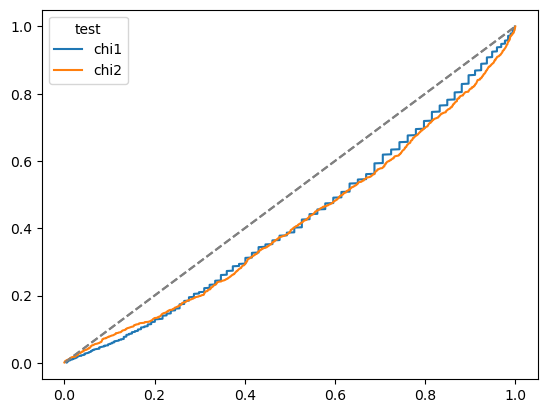

In [9]:
m, n = 1000, 100
data = expon.rvs(size = (m,n), scale = 2)
chi1(data, m, n, 'chi1')
chi2(data, m, n, 'chi2')


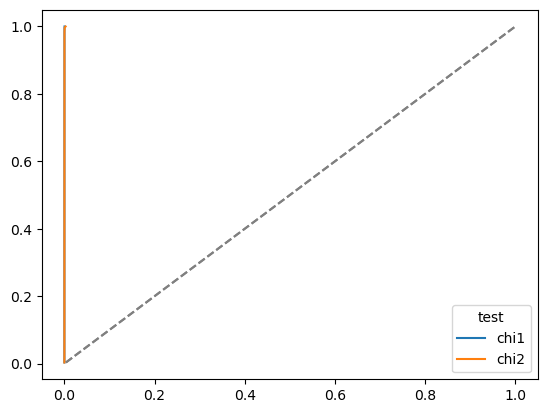

In [10]:
m, n = 300, 300
data = gamma.rvs(2, size = (m,n), loc = 0, scale = 2)
chi1(data, m, n, 'chi1')
chi2(data, m, n, 'chi2')


# 3

In [11]:
data = norm.rvs(loc = 0, scale = 1, size = (100000, 1000))
T = [anderson(data[i], dist='norm').statistic for i in range(m)]
AD_norm = ECDF(T)

In [12]:
def normtests(data, m, n, s):
    pv1 = np.sort([1 - AD_norm(anderson(data[i], dist='norm').statistic) for i in range(m)]) #мб не так
    pv2 = np.sort([shapiro(data[i]).pvalue for i in range(m)])
    pv3 = np.sort(normaltest(data, axis = 1).pvalue)
    R = np.arange(1,m+1)/m
    plt.plot(pv1, R, label = 'anderson')
    plt.plot(pv2, R, label = 'shapiro')
    plt.plot(pv3, R, label = 'normaltest')
    plt.plot(R,R, linestyle='dashed', color='gray')
    plt.legend(title = 'test')
    plt.title(s)
def normtestspower(data, n, m):
    alpha = 0.05
    arr = [0]*3
    # data = [np.sort(data[i]) for i in range(m)]
    arr[0] = np.mean(np.array([int((1 - AD_norm(anderson(data[i], dist='norm').statistic)) < alpha) for i in range(m)]))
    arr[1] = np.mean(np.array([int(shapiro(data[i]).pvalue < alpha) for i in range(m)]))
    arr[2] = np.mean(np.array([int(normaltest(data[i]).pvalue < alpha) for i in range(m)]))
    return arr

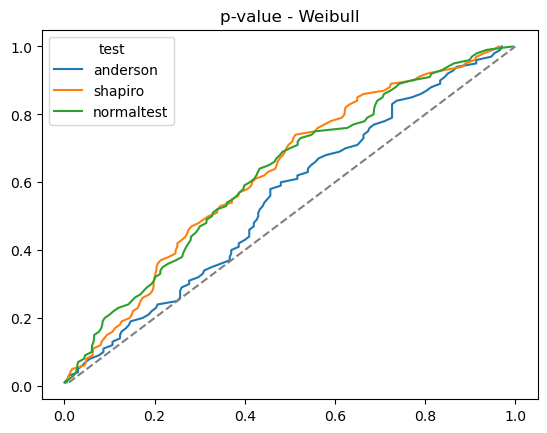

In [13]:

m, n = 100, 100
c=3
data = scipy.stats.weibull_min.rvs(3, loc=0, scale=1, size=(m,n))
normtests(data, m, n, 'p-value - Weibull' )

Text(0.5, 1.0, '$Power: Weibull(\\lambda)$')

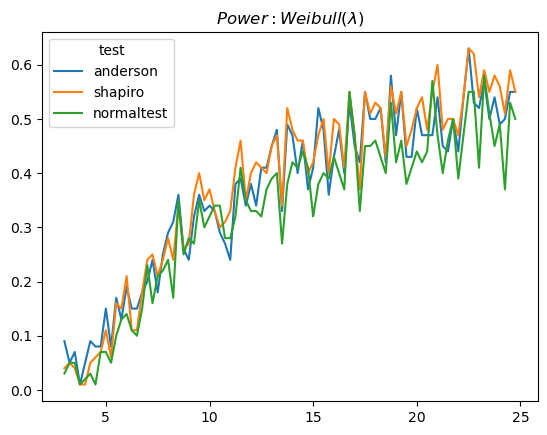

In [14]:
m=100
N=50
l = np.arange(12, 100)/4
p=np.zeros((3,len(l)))
for i, lam in enumerate(l):
    data = weibull_min.rvs(lam , loc=0, scale=1, size=(m, N))
    p[0][i],p[1][i], p[2][i] = normtestspower(data, N, m)

plt.plot(l, p[0], label = 'anderson')
plt.plot(l, p[1],  label = 'shapiro')
plt.plot(l, p[2],  label = 'normaltest')
plt.legend(title = 'test')
plt.title(r'$Power: Weibull(\lambda)$')

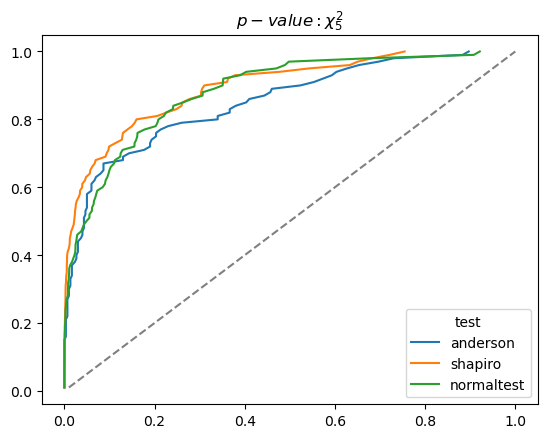

In [15]:
m, n = 100, 100
data = gamma.rvs(a=10, loc=0, scale=2, size=(m,n))
normtests(data, m, n, f'$p-value: \chi^2_{5}$' )


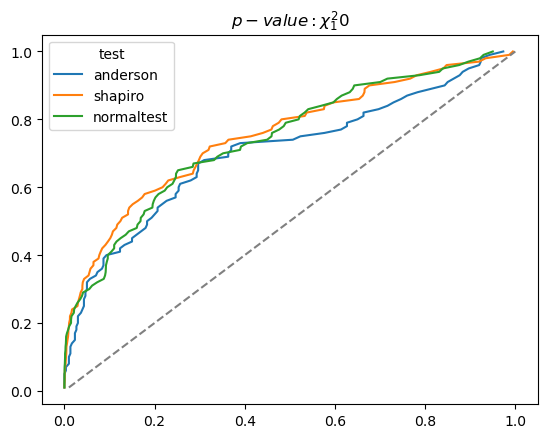

In [16]:
m, n = 100, 100
data = gamma.rvs(a=20, loc=0, scale=2, size=(m,n))
normtests(data, m, N, f'$p-value: \chi^2_{10}$' )


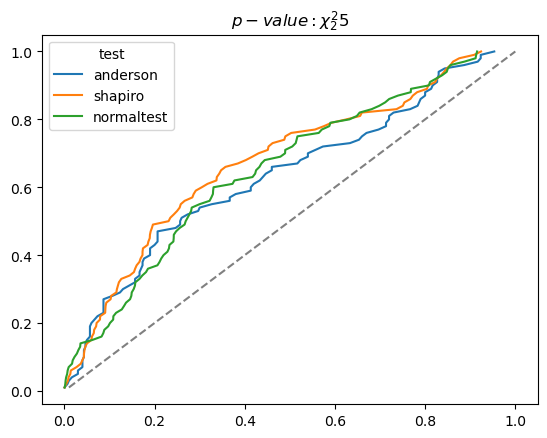

In [17]:
m, n = 100, 100
data = gamma.rvs(a=50, loc=0, scale=2, size=(m,n))
normtests(data, m, N, f'$p-value: \chi^2_{25}$' )


Text(0.5, 1.0, '$Power:  \\chi^2_{n}$')

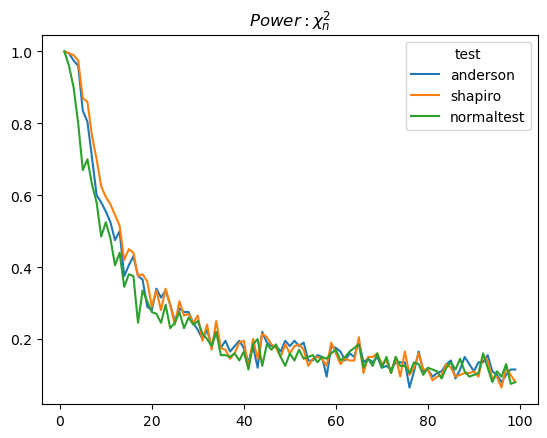

In [18]:
N, m = 50, 200
n = np.arange(1, 100)
p=np.zeros((3,len(n)))
for i, k in enumerate(n):
    data = gamma.rvs(a = k/2, loc=0, scale=2, size=(m,N))
    p[0][i],p[1][i], p[2][i] = normtestspower(data, N, m)
plt.plot(n, p[0], label = 'anderson')
plt.plot(n, p[1],  label = 'shapiro')
plt.plot(n, p[2],  label = 'normaltest')
plt.legend(title = 'test')
plt.title(r'$Power:  \chi^2_{n}$')

C:\Users\User\anaconda\Lib\site-packages\scipy\stats\_axis_nan_policy.py:563: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


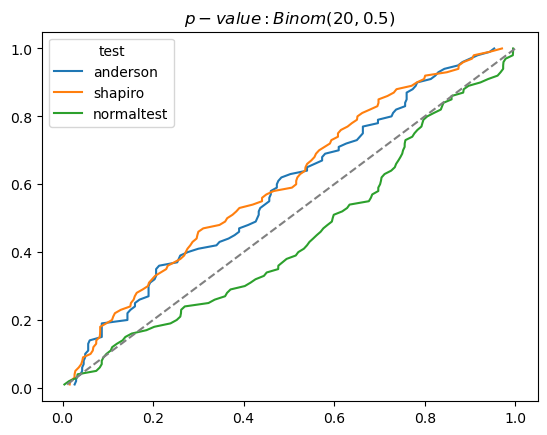

In [19]:
m=100
N=10
n=20
data = binom.rvs(n = n, p= 0.5,  size=(m,N))
normtests(data, m, N, f'$p-value: Binom({n}, 0.5 )$' )

Text(0.5, 1.0, '$Power: Binom({n}, 0.5 )')

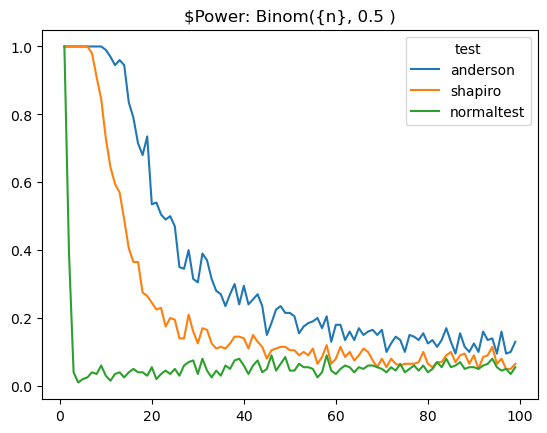

In [20]:
N, m = 50, 200
n = np.arange(1, 100)
p=np.zeros((3,len(n)))
for i, k in enumerate(n):
    data = binom.rvs(n = k, p= 0.5,  size=(m,N))
    p[0][i],p[1][i], p[2][i] = normtestspower(data, N, m)
plt.plot(n, p[0], label = 'anderson')
plt.plot(n, p[1],  label = 'shapiro')
plt.plot(n, p[2],  label = 'normaltest')
plt.legend(title = 'test')
plt.title(r'$Power: Binom({n}, 0.5 )')